# 7. 순환 신경망
## 7.2 LSTM

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/pytorch_dlbro

/content/gdrive/My Drive/pytorch_dlbro


In [2]:
df = pd.read_csv("./data/kospi.csv")

In [3]:
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


In [6]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [7]:
# Dataset
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [10]:
def seq_data(x, y, sequence_length):
    
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])
    
    x_seq = np.array(x_seq)
    y_seq = np.array(y_seq)
    
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

In [11]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [12]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [13]:
# RNN
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [14]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*sequence_length, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # <- cell state 추가
        out, _ = self.lstm(x, (h0, c0)) # output, (hn, cn): cell state와 hidden state만 반환
        out = out.reshape(out.shape[0], -1) # <- state 추가
        out = self.fc(out)
        return out

In [15]:
model = LSTM(input_size=input_size, 
                   hidden_size=hidden_size, 
                   sequence_length=sequence_length, 
                   num_layers=num_layers, device=device)    

model = model.to(device)             

In [16]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 301 
optimizer = optim.Adam(model.parameters(), lr=lr)


In [17]:
loss_graph = []
n = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for data in train_loader:
        
        seq, target = data # 배치 데이터 
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.3219
[epoch: 100] loss: 0.0010
[epoch: 200] loss: 0.0010
[epoch: 300] loss: 0.0009


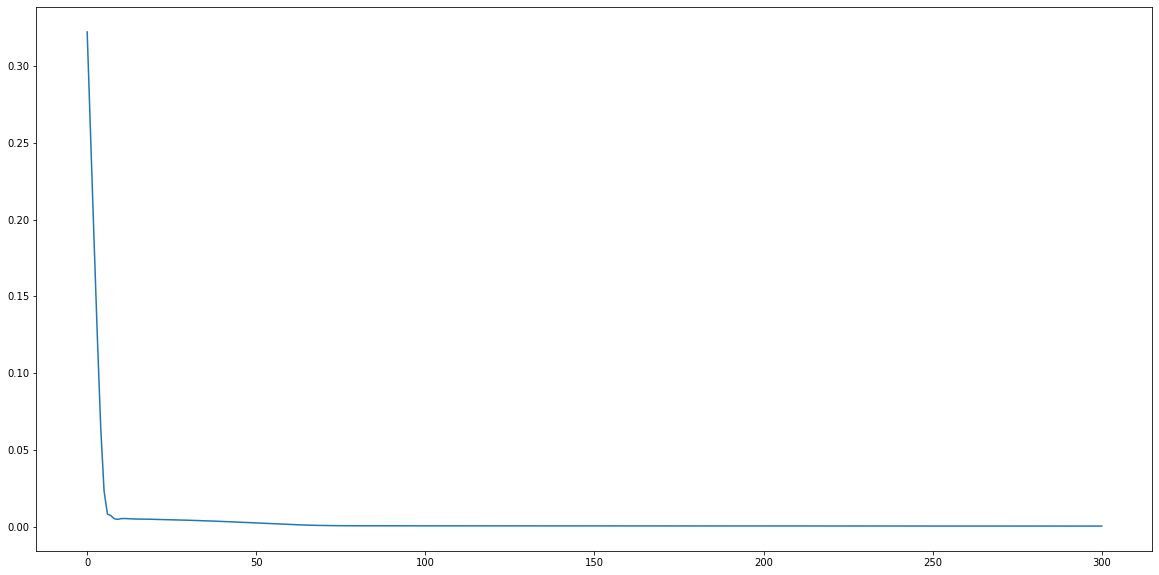

In [18]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show() 

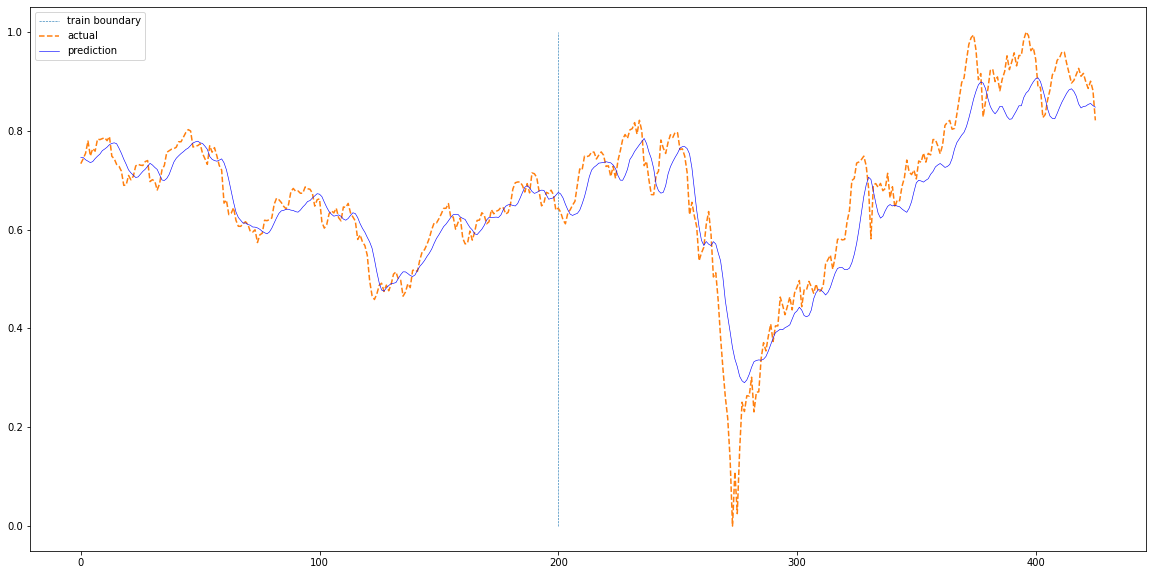

In [19]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []

    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show() 